<a href="https://colab.research.google.com/github/ahtajdini/DDescent-in-NN/blob/main/Double_Descent_in_CNN_with_regularization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Descent 

## Double Descent in NN. Ex: CIFAR-10

I found this cool paper, arxiv:1912.02292 by openAI that the picture of the assignment seems to be from that. One of the cases of double descent (DD) in the paper is standard Conv NN. DD is dominant when there is a labeled noise. I reproduce their result here using colab GPU. I could not go all the way to the width parameter k they have in the paper, but I was able to find the Double Descent behavior

### without regularization

In [ ]:
#@title downloading dataset
train_ds, test_ds = tf.keras.datasets.cifar10.load_data()

In [ ]:
#@title number to objects
num_to_obj ={0: "airplane", 1: "automobile" ,2: "bird", 3: "cat", 4: "deer" , 5: "dog",6:"frog",7:"horse",8:"ship",9:"truck"}	

In [ ]:
#@title Adding Noise function

def label_noise(yset, p,num_class):
  arr= np.copy(yset)
  count=0
  for y in arr:
    num_rand = np.random.binomial(1,p)
    if num_rand==1:
       y[0]=np.random.choice(np.delete(np.arange(num_class),y[0]))
       count+=1

  return arr

In [ ]:
#@title train,test

num_class=10
#normalization, nn.Conv asks for float32,permute is to make it lie (N,C,H,W)
x_train_ds = torch.from_numpy(train_ds[0]/255).to(torch.float32).permute(0,3,1,2)
y_train_ds = torch.from_numpy(train_ds[1])
y_train_ds_20 = label_noise(y_train_ds,0.2,num_class)
y_train_ds_10 = label_noise(y_train_ds,0.1,num_class)
x_test_ds = torch.from_numpy(test_ds[0]/255).to(torch.float32).permute(0,3,1,2)
y_test_ds = torch.from_numpy(test_ds[1])


y_test_ds_20 = label_noise(y_test_ds,0.2,num_class)
y_test_ds_10 = label_noise(y_test_ds,0.1,num_class)

In [ ]:
#@title train, val, test datasets

val_size= 10000
train_size = len(train_ds[0]) - val_size

train_dataset = list(zip(x_train_ds,y_train_ds))
test_dataset = list(zip(x_test_ds,y_test_ds))

train_dataset_20 = list(zip(x_train_ds,y_train_ds_20))
test_dataset_20 = list(zip(x_test_ds,y_test_ds_20))

train_dataset_10 = list(zip(x_train_ds,y_train_ds_10))
test_dataset_10 = list(zip(x_test_ds,y_test_ds_10))

In [ ]:
#@title shuffling data
train, val = random_split( train_dataset, [train_size,val_size])

train_20, val_20 = random_split( train_dataset_20, [train_size,val_size])

train_10, val_10 = random_split( train_dataset_10, [train_size,val_size])

In [ ]:
#@title batches
batch_size= 64
train_loader = DataLoader(train,batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset,len(test_dataset),shuffle=True,num_workers=2)
val = DataLoader(val,len(val),shuffle=True,num_workers=2)
val=next(iter(val))
test=next(iter(test_loader))



train_loader_20 = DataLoader(train_20,batch_size,shuffle=True,num_workers=2)
test_loader_20 = DataLoader(test_dataset_20,len(test_dataset_20),shuffle=True,num_workers=2)
val_20 = DataLoader(val_20,len(val_20),shuffle=True,num_workers=2)
val_20=next(iter(val_20))
test_20=next(iter(test_loader_20))


train_loader_10 = DataLoader(train_10,batch_size,shuffle=True,num_workers=2)
test_loader_10 = DataLoader(test_dataset_10,len(test_dataset_10),shuffle=True,num_workers=2)
val_10 = DataLoader(val_10,len(val_10),shuffle=True,num_workers=2)
val_10=next(iter(val_10))
test_10=next(iter(test_loader_10))

images.shape: torch.Size([64, 3, 32, 32])


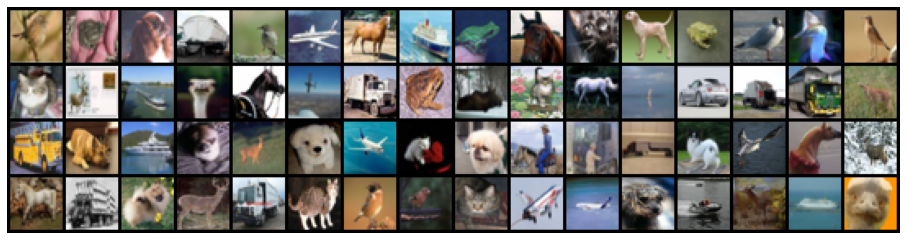

In [ ]:
#@title sample batch
for images, labels in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    #make_grid has to have (B,C,H,W), imshow has to have (# pixels,#pixels, len)
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
#@title Standard CNN $[k, 2k, 2k, 4k, 8k]$
def accuracy(out,labels):
  _,preds = torch.max(out, dim=1)
  return torch.sum(preds==labels)/len(preds)


def ConvLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)


#I used 4 pool layer (2,2). This can only work with at least (16,16) pictures, num_layers has 4 Conv and 1 fully connected
class myConv(nn.Module):
  def __init__(self,input_size=32,channel=3,width=32,num_layers=5, fforward=256,num_classes=10,dropout=0, device=torch.device("cuda")):
    super(myConv,self).__init__()
    self.device=device
  

    self.layers = nn.ModuleList(
        [nn.Sequential( ConvLayer(channel,width),nn.BatchNorm2d(width),nn.ReLU(), nn.MaxPool2d(1,1)  )]
        +[nn.Sequential( ConvLayer(width,2*width),nn.BatchNorm2d(2*width),nn.ReLU(), nn.MaxPool2d(2,2))]
        +[nn.Sequential( ConvLayer(2*width,4*width),nn.BatchNorm2d(4*width),nn.ReLU(), nn.MaxPool2d(2,2))]
        +[nn.Sequential( ConvLayer(4*width,8*width),nn.BatchNorm2d(8*width),nn.ReLU(), nn.MaxPool2d(8,8))]
        +[nn.Sequential(
        nn.Flatten(),nn.Linear(8*width, fforward),
        nn.ReLU(),
        nn.Linear(fforward,10) )]
        
        
    )
    self.dropout=nn.Dropout(dropout)

  def forward(self,x,training):
      out=x
      for layer in self.layers:
        out = layer(out)
        if training: out =self.dropout(out)
      
      return out

  def compute_loss_train(self,batch,training):
      x ,labels = batch
      x=x.to(self.device)
      labels = labels.to(self.device)
      #x~(B,C,H,W),labels~(B,1)
      labels=labels[:,0]

      out = self.forward(x,training)

      acc = accuracy(out,labels)

      loss= F.cross_entropy(out, labels)


      return loss , {"loss_s": loss.item(), "acc_s":acc.item()}

  def compute_loss_val(self,val):
        x ,labels = val
        #print(trg.shape, labels.shape)
        x=x.to(self.device)
        labels = labels.to(self.device)

        labels=labels[:,0]
        out = self.forward(x,False)
        #print(out.shape, labels.shape)
        #now out has the shape (N,trg_size,sequence_length)
      
        acc = accuracy(out,labels)
        loss= F.cross_entropy(out, labels)
        return  {"loss_s": loss.item(), "acc_s":acc.item()}

  def val_epoch_end(self,outputs):
        losses= np.array([x["loss_s"] for x in outputs])
        accs = np.array([x["acc_s"] for x in outputs])

        return {"loss_s": losses.mean(), "acc_s": accs.mean()}

In [ ]:
#@title fit function
def fit(epochs,model,lr,train_loader,val, beta1=0.9, beta2=0.999,opt= torch.optim.Adam):
  history=[]

  optimizer = opt(model.parameters(), lr, [beta1,beta1])

  for epoch in range(epochs):
    outputs=[]
    for batch in train_loader:
      loss, dic = model.compute_loss_train(batch,True)

      outputs.append(dic)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    train_result = model.val_epoch_end(outputs)
    val_result= model.compute_loss_val(val)
    tes_result=  model.compute_loss_val(test)
    if epoch %10==0: print("Epoch %d: Train loss is %.4f, Train Acc is %.4f. The Validation loss is %.4f, Validation Acc is %.4f. Test loss is %.4f, test acc is %.4f." \
          %(epoch+1, train_result["loss_s"],train_result["acc_s"], val_result["loss_s"],val_result["acc_s"], tes_result["loss_s"],tes_result["acc_s"]) )
    history.append([train_result,val_result, tes_result])
    
  return history

In [ ]:
#@title Recording data for different epochs and width sizes
history=[]
final=[]
device = torch.device("cuda")
for k in range(1,22):
  print(k)
  model= myConv(width=k, fforward = 4*k).to(device)
  history.append([k,fit(150,model,0.002,train_loader_20,val_20)])
  res= model.compute_loss_val(test)
  print("The Test error is %.4f" % (1-res["acc_s"]))
  final.append([k,model.compute_loss_val(test)])
 

  with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise'+str(k)+'.pkl', 'wb') as f:

    pickle.dump([history,final], f)

In [ ]:
#@title sample width = 22
history=[]
final=[]
device = torch.device("cuda")
for k in range(22,23):
  print(k)
  model= myConv(width=k, fforward = 4*k).to(device)
  history.append([k,fit(150,model,0.002,train_loader_20,val_20)])
  res= model.compute_loss_val(test)
  print("The Test error is %.4f" % (1-res["acc_s"]))
  final.append([k,model.compute_loss_val(test)])
 

  with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise'+str(k)+'.pkl', 'wb') as f:

    pickle.dump([history,final], f)

22
Epoch 1: Train loss is 1.8158, Train Acc is 0.3912. The Validation loss is 1.6460, Validation Acc is 0.4746. Test loss is 1.2599, test acc is 0.5791.
Epoch 11: Train loss is 0.8329, Train Acc is 0.7573. The Validation loss is 1.7102, Validation Acc is 0.5603. Test loss is 1.0130, test acc is 0.6914.
Epoch 21: Train loss is 0.3223, Train Acc is 0.8928. The Validation loss is 3.1256, Validation Acc is 0.5094. Test loss is 1.7619, test acc is 0.6182.
Epoch 31: Train loss is 0.1936, Train Acc is 0.9356. The Validation loss is 4.0021, Validation Acc is 0.4894. Test loss is 2.3836, test acc is 0.5884.
Epoch 41: Train loss is 0.1442, Train Acc is 0.9513. The Validation loss is 4.5857, Validation Acc is 0.4869. Test loss is 2.5961, test acc is 0.5959.
Epoch 51: Train loss is 0.1163, Train Acc is 0.9603. The Validation loss is 4.9530, Validation Acc is 0.4877. Test loss is 2.9523, test acc is 0.5867.
Epoch 61: Train loss is 0.0954, Train Acc is 0.9677. The Validation loss is 5.2482, Validati

In [ ]:
#@title putting data together

history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise"+str(21)+".pkl", "rb") as f:
    history.append( pickle.load(f))

epochs = 150
width = 22

train_loss=np.zeros((width,epochs))
train_accuracy =np.zeros((width,epochs))
val_loss=np.zeros((width,epochs))
val_accuracy = np.zeros((width,epochs))
test_loss = np.zeros((width,epochs))
test_accuracy = np.zeros((width,epochs))

for k in range(21):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k][1][i][2]["acc_s"]

history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise"+str(22)+".pkl", "rb") as f:
    history.append( pickle.load(f))

num=21
k=0
for i in range(epochs):
    train_loss[num,i] = history[-1][0][k][1][i][0]["loss_s"]
    train_accuracy[num,i] = history[-1][0][k][1][i][0]["acc_s"]
    val_loss[num,i] = history[-1][0][k][1][i][1]["loss_s"]
    val_accuracy[num,i] = history[-1][0][k][1][i][1]["acc_s"]
    test_loss[num,i] = history[-1][0][k][1][i][2]["loss_s"]
    test_accuracy[num,i] = history[-1][0][k][1][i][2]["acc_s"]

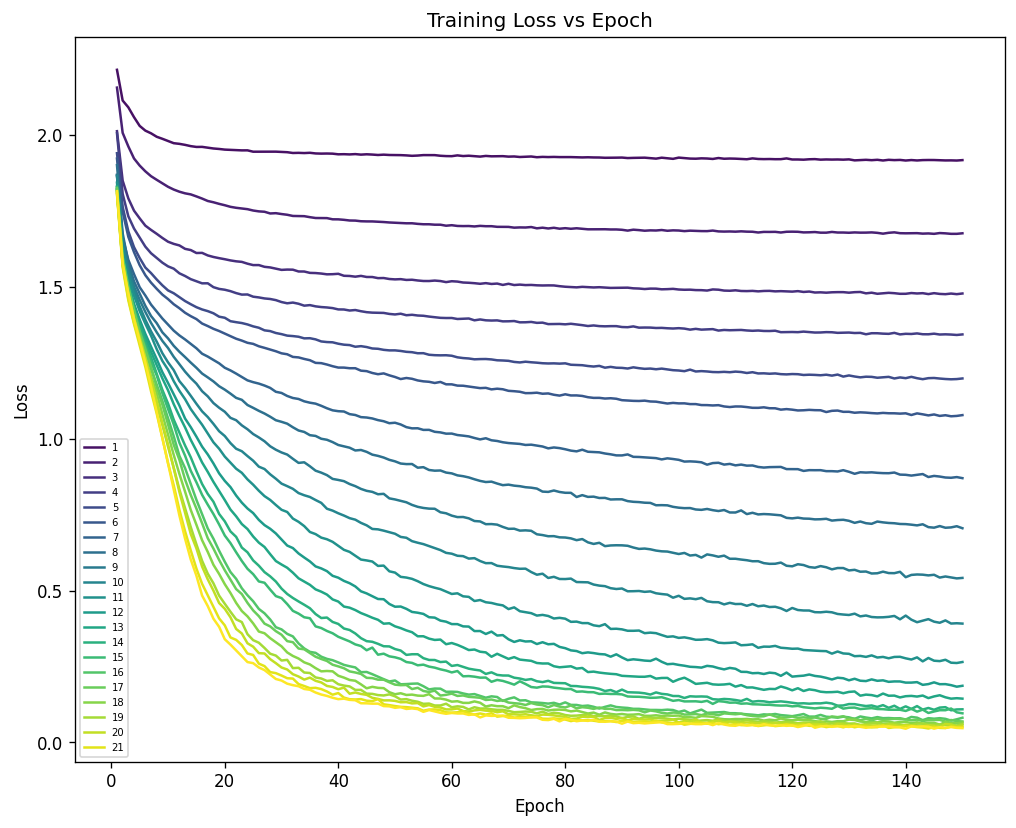

In [ ]:
#@title loss vs epoch
viridis = cm.get_cmap('viridis', width+1)
colormap = viridis
colors = [colormap(i) for i in np.linspace(0, 1, width+1)]
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=120)
for k in range(1,1+width):
  plt.plot(np.arange(1,epochs+1),train_loss[k-1],color = colors[k])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend(range(1,22),loc="lower left",prop={"size":6})
plt.show()

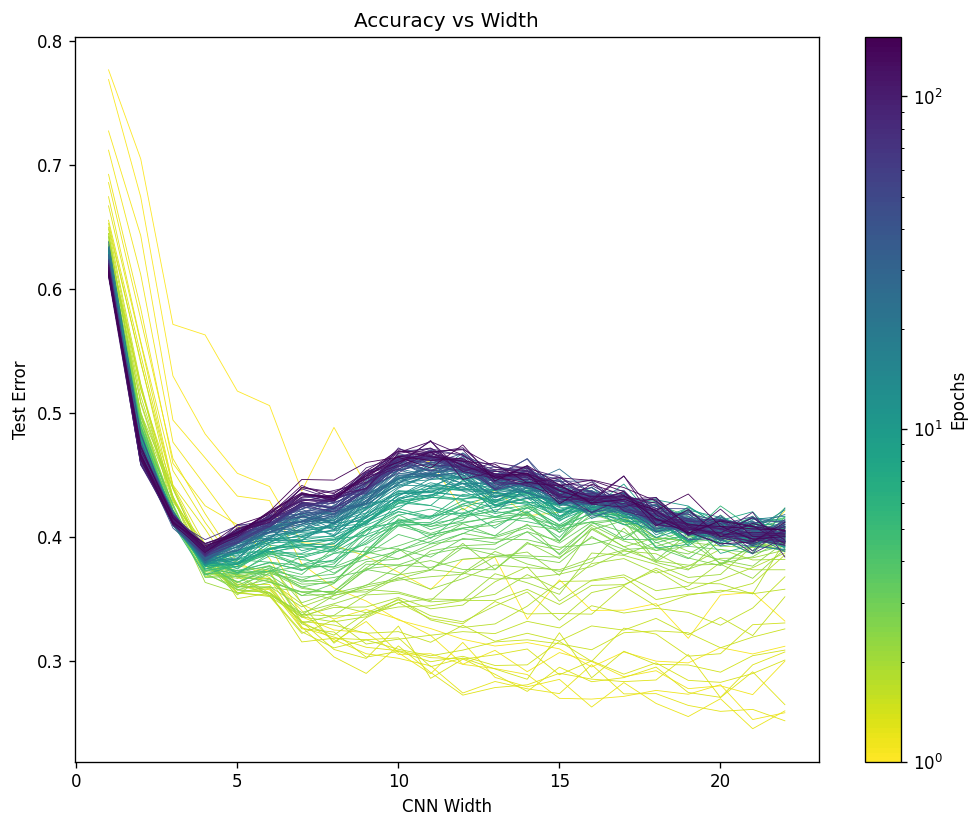

In [ ]:
#@title Accuracy vs model params
from matplotlib.pyplot import figure
viridis = cm.get_cmap('viridis', epochs).reversed()
colormap = viridis
colors = [colormap(i) for i in np.linspace(0, 1, epochs)]
figure(figsize=(10, 8), dpi=120)
for epoch in range(epochs):
  plt.plot(np.arange(1,1+width),1-test_accuracy[:,epoch], color = colors[epoch],linewidth = 0.5)
plt.xlabel("CNN Width")
plt.ylabel("Test Error")
plt.title("Accuracy vs Width")
#plt.legend(range(3,14),loc="lower left",prop={"size":12})

sm = plt.cm.ScalarMappable(cmap=viridis, norm=mpl.colors.LogNorm( 1, epochs+1))
#plt.colorbar(sm)
cbar = plt.colorbar(sm)
cbar.set_label("Epochs")
plt.show()

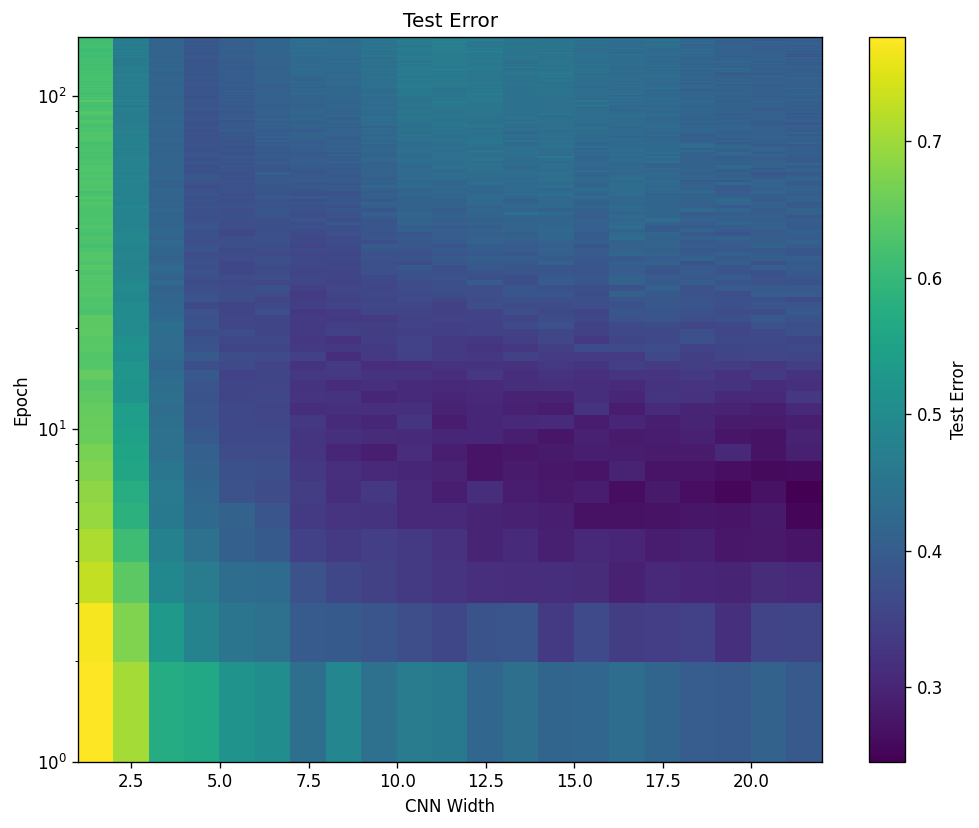

In [ ]:
#@title color map for test error vs epoch and model params
fig, ax = plt.subplots(figsize=(10, 8),dpi=120)
cmap = ax.pcolormesh(np.arange(1,1+width), np.arange(1,1+epochs), (1-test_accuracy).T,cmap ="viridis")
ax.set_yscale('log')
ax.set_xlabel("CNN Width")
ax.set_ylabel("Epoch")
ax.set_title("Test Error")
cbar = plt.colorbar(cmap)
cbar.set_label("Test Error")
#fig.colorbar(cmap)
plt.show(fig)

### **With regularization**

In [ ]:
#@title model with regularization AdamW
def accuracy(out,labels):
  _,preds = torch.max(out, dim=1)
  return torch.sum(preds==labels)/len(preds)


def ConvLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)


#I used 4 pool layer (2,2). This can only work with at least (16,16) pictures, num_layers has 4 Conv and 1 fully connected
class myConv(nn.Module):
  def __init__(self,input_size=32,channel=3,width=32,num_layers=5, fforward=256,num_classes=10,dropout=0, device=torch.device("cuda")):
    super(myConv,self).__init__()
    self.device=device
  

    self.layers = nn.ModuleList(
        [nn.Sequential( ConvLayer(channel,width),nn.BatchNorm2d(width),nn.ReLU(), nn.MaxPool2d(1,1)  )]
        +[nn.Sequential( ConvLayer(width,2*width),nn.BatchNorm2d(2*width),nn.ReLU(), nn.MaxPool2d(2,2))]
        +[nn.Sequential( ConvLayer(2*width,4*width),nn.BatchNorm2d(4*width),nn.ReLU(), nn.MaxPool2d(2,2))]
        +[nn.Sequential( ConvLayer(4*width,8*width),nn.BatchNorm2d(8*width),nn.ReLU(), nn.MaxPool2d(8,8))]
        +[nn.Sequential(
        nn.Flatten(),nn.Linear(8*width, fforward),
        nn.ReLU(),
        nn.Linear(fforward,10) )]
        
        
    )
    self.dropout=nn.Dropout(dropout)

  def forward(self,x,training):
      out=x
      for layer in self.layers:
        out = layer(out)
        if training: out =self.dropout(out)
      
      return out

  def compute_loss_train(self,batch,training):
      x ,labels = batch
      x=x.to(self.device)
      labels = labels.to(self.device)
      #x~(B,C,H,W),labels~(B,1)
      labels=labels[:,0]

      out = self.forward(x,training)

      acc = accuracy(out,labels)

      loss= F.cross_entropy(out, labels)


      return loss , {"loss_s": loss.item(), "acc_s":acc.item()}

  def compute_loss_val(self,val):
        x ,labels = val
        #print(trg.shape, labels.shape)
        x=x.to(self.device)
        labels = labels.to(self.device)

        labels=labels[:,0]
        out = self.forward(x,False)
        #print(out.shape, labels.shape)
        #now out has the shape (N,trg_size,sequence_length)
      
        acc = accuracy(out,labels)
        loss= F.cross_entropy(out, labels)
        return  {"loss_s": loss.item(), "acc_s":acc.item()}

  def val_epoch_end(self,outputs):
        losses= np.array([x["loss_s"] for x in outputs])
        accs = np.array([x["acc_s"] for x in outputs])

        return {"loss_s": losses.mean(), "acc_s": accs.mean()}

def fit(epochs,model,lr,mu,train_loader,val, beta1=0.9, beta2=0.999,opt= torch.optim.AdamW):
  history=[]

  optimizer = opt(model.parameters(), lr, [beta1,beta1],weight_decay = mu)

  for epoch in range(epochs):
    outputs=[]
    for batch in train_loader:
      loss, dic = model.compute_loss_train(batch,True)

      outputs.append(dic)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    train_result = model.val_epoch_end(outputs)
    val_result= model.compute_loss_val(val)
    tes_result=  model.compute_loss_val(test)
    if epoch %10==0: print("Epoch %d: Train loss is %.4f, Train Acc is %.4f. The Validation loss is %.4f, Validation Acc is %.4f. Test loss is %.4f, test acc is %.4f." \
          %(epoch+1, train_result["loss_s"],train_result["acc_s"], val_result["loss_s"],val_result["acc_s"], tes_result["loss_s"],tes_result["acc_s"]) )
    history.append([train_result,val_result, tes_result])
    
  return history

def fit2(epochs,model,lr,mu,train_loader,val, beta1=0.9, beta2=0.999,opt= torch.optim.Adam):
  history=[]

  optimizer = opt(model.parameters(), lr, [beta1,beta1],weight_decay = mu)
  alpha = lr
  for epoch in range(epochs):
    alpha= lr/(1+epoch/40)
    optimizer = opt(model.parameters(), alpha, [beta1,beta1],weight_decay = mu)
    outputs=[]
    for batch in train_loader:
      loss, dic = model.compute_loss_train(batch,True)

      outputs.append(dic)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    train_result = model.val_epoch_end(outputs)
    val_result= model.compute_loss_val(val)
    tes_result=  model.compute_loss_val(test)
    if epoch %10==0: print("Epoch %d: Train loss is %.4f, Train Acc is %.4f. The Validation loss is %.4f, Validation Acc is %.4f. Test loss is %.4f, test acc is %.4f." \
          %(epoch+1, train_result["loss_s"],train_result["acc_s"], val_result["loss_s"],val_result["acc_s"], tes_result["loss_s"],tes_result["acc_s"]) )
    history.append([train_result,val_result, tes_result])
    
  return history

In [ ]:
#@title choosing the regularization parameter
k=10
device = torch.device("cuda")
history=[]
for alpha in range(0,5):

  mu = 10**(-alpha)
  model= myConv(width=k, fforward = 4*k).to(device)
  print(mu)
  history.append([alpha,fit(200,model,0.002,mu,train_loader_20,val_20)])





In [ ]:
#@title Recording data for different epochs and width sizes
history=[]
final=[]
device = torch.device("cuda")
for k in range(1,22):
  print(k)
  model= myConv(width=k, fforward = 4*k).to(device)
  history.append([k,fit(150,model,0.002,0.01,train_loader_20,val_20)])
  res= model.compute_loss_val(test)
  print("The Test error is %.4f" % (1-res["acc_s"]))
  final.append([k,model.compute_loss_val(test)])
 

  with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-regularized'+str(k)+'.pkl', 'wb') as f:

    pickle.dump([history,final], f)

1
Epoch 1: Train loss is 2.2397, Train Acc is 0.1492. The Validation loss is 2.1494, Validation Acc is 0.1786. Test loss is 2.0624, test acc is 0.1985.
Epoch 11: Train loss is 2.0104, Train Acc is 0.2664. The Validation loss is 1.9945, Validation Acc is 0.2785. Test loss is 1.8277, test acc is 0.3341.
Epoch 21: Train loss is 1.9808, Train Acc is 0.2831. The Validation loss is 1.9786, Validation Acc is 0.2866. Test loss is 1.7891, test acc is 0.3422.
Epoch 31: Train loss is 1.9672, Train Acc is 0.2912. The Validation loss is 1.9519, Validation Acc is 0.2951. Test loss is 1.7632, test acc is 0.3519.
Epoch 41: Train loss is 1.9646, Train Acc is 0.2920. The Validation loss is 1.9445, Validation Acc is 0.3015. Test loss is 1.7528, test acc is 0.3624.
Epoch 51: Train loss is 1.9628, Train Acc is 0.2952. The Validation loss is 1.9513, Validation Acc is 0.2982. Test loss is 1.7647, test acc is 0.3639.
Epoch 61: Train loss is 1.9616, Train Acc is 0.2957. The Validation loss is 1.9479, Validatio

In [ ]:
#@title Recording data for different epochs and width sizes
history=[]
final=[]
device = torch.device("cuda")
for k in range(1,23):
  print(k)
  model= myConv(width=k, fforward = 4*k).to(device)
  history.append([k,fit(200,model,0.0005,0.01,train_loader_20,val_20)])
  res= model.compute_loss_val(test)
  print("The Test error is %.4f" % (1-res["acc_s"]))
  final.append([k,model.compute_loss_val(test)])
 

  with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-adamw-regularized'+str(k)+'.pkl', 'wb') as f:

    pickle.dump([history,final], f)

In [ ]:
#@title Recording data for different epochs and width sizes
history=[]
final=[]
device = torch.device("cuda")
for k in range(7,23):
  print(k)
  model= myConv(width=k, fforward = 4*k).to(device)
  history.append([k,fit(200,model,0.0005,0.01,train_loader_20,val_20)])
  res= model.compute_loss_val(test)
  print("The Test error is %.4f" % (1-res["acc_s"]))
  final.append([k,model.compute_loss_val(test)])
 

  with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-adamw-regularized0.01-from-6-to'+str(k)+'.pkl', 'wb') as f:

    pickle.dump([history,final], f)
  torch.cuda.empty_cache()

In [ ]:
#@title combining data

history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-adamw-regularized6.pkl", "rb") as f:
    history.append( pickle.load(f))

epochs = 200
width = 21

train_loss=np.zeros((width,epochs))
train_accuracy =np.zeros((width,epochs))
val_loss=np.zeros((width,epochs))
val_accuracy = np.zeros((width,epochs))
test_loss = np.zeros((width,epochs))
test_accuracy = np.zeros((width,epochs))

for k in range(6):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k][1][i][2]["acc_s"]


history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-adamw-regularized0.01-from-6-to22.pkl", "rb") as f:
    history.append( pickle.load(f))
num=6

for k in range(6,21):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k-num][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k-num][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k-num][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k-num][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k-num][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k-num][1][i][2]["acc_s"]

dic={}
dic[0.01] = [train_loss, train_accuracy, val_loss, val_accuracy, test_loss,test_accuracy]

direc_without = "/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-lrsmall19 (1).pkl"


history=[]
with open(direc_without, "rb") as f:
    history.append( pickle.load(f))

epochs = 200
width = 21

train_loss=np.zeros((width,epochs))
train_accuracy =np.zeros((width,epochs))
val_loss=np.zeros((width,epochs))
val_accuracy = np.zeros((width,epochs))
test_loss = np.zeros((width,epochs))
test_accuracy = np.zeros((width,epochs))

for k in range(19):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k][1][i][2]["acc_s"]



# history=[]
# final=[]
# device = torch.device("cuda")
# for k in range(20,22):
#   print(k)
#   model= myConv(width=k, fforward = 4*k).to(device)
#   history.append([k,fit(200,model,0.0005,train_loader_20,val_20)])
#   res= model.compute_loss_val(test)
#   print("The Test error is %.4f" % (1-res["acc_s"]))
#   final.append([k,model.compute_loss_val(test)])
 

#   with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-without_reg19to'+str(k)+'.pkl', 'wb') as f:

#     pickle.dump([history,final], f)
#   torch.cuda.empty_cache()

history=[]
with open('/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-without_reg19to'+str(21)+'.pkl', "rb") as f:
    history.append( pickle.load(f))
num=19

for k in range(num,21):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k-num][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k-num][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k-num][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k-num][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k-num][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k-num][1][i][2]["acc_s"]


dic[0] = [train_loss, train_accuracy, val_loss, val_accuracy, test_loss,test_accuracy]


history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-reg0.1-1-to9.pkl", "rb") as f:
    history.append( pickle.load(f))

epochs = 200
width = 21

train_loss=np.zeros((width,epochs))
train_accuracy =np.zeros((width,epochs))
val_loss=np.zeros((width,epochs))
val_accuracy = np.zeros((width,epochs))
test_loss = np.zeros((width,epochs))
test_accuracy = np.zeros((width,epochs))

for k in range(9):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k][1][i][2]["acc_s"]


history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIDAR-10-labeled-20-noise-reg0.1-from9to21.pkl", "rb") as f:
    history.append( pickle.load(f))
num=9

for k in range(9,21):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k-num][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k-num][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k-num][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k-num][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k-num][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k-num][1][i][2]["acc_s"]

dic[0.1] = [train_loss, train_accuracy, val_loss, val_accuracy, test_loss,test_accuracy]



history=[]
with open("/content/drive/MyDrive/Colab Notebooks/CIFAR-10-labeled-20-noise-reg1-from1to21.pkl", "rb") as f:
    history.append( pickle.load(f))

epochs = 200
width = 21

train_loss=np.zeros((width,epochs))
train_accuracy =np.zeros((width,epochs))
val_loss=np.zeros((width,epochs))
val_accuracy = np.zeros((width,epochs))
test_loss = np.zeros((width,epochs))
test_accuracy = np.zeros((width,epochs))

for k in range(21):
    for i in range(epochs):
        train_loss[k,i] = history[-1][0][k][1][i][0]["loss_s"]
        train_accuracy[k,i] = history[-1][0][k][1][i][0]["acc_s"]
        val_loss[k,i] = history[-1][0][k][1][i][1]["loss_s"]
        val_accuracy[k,i] = history[-1][0][k][1][i][1]["acc_s"]
        test_loss[k,i] = history[-1][0][k][1][i][2]["loss_s"]
        test_accuracy[k,i] = history[-1][0][k][1][i][2]["acc_s"]

dic[1] = [train_loss, train_accuracy, val_loss, val_accuracy, test_loss,test_accuracy]

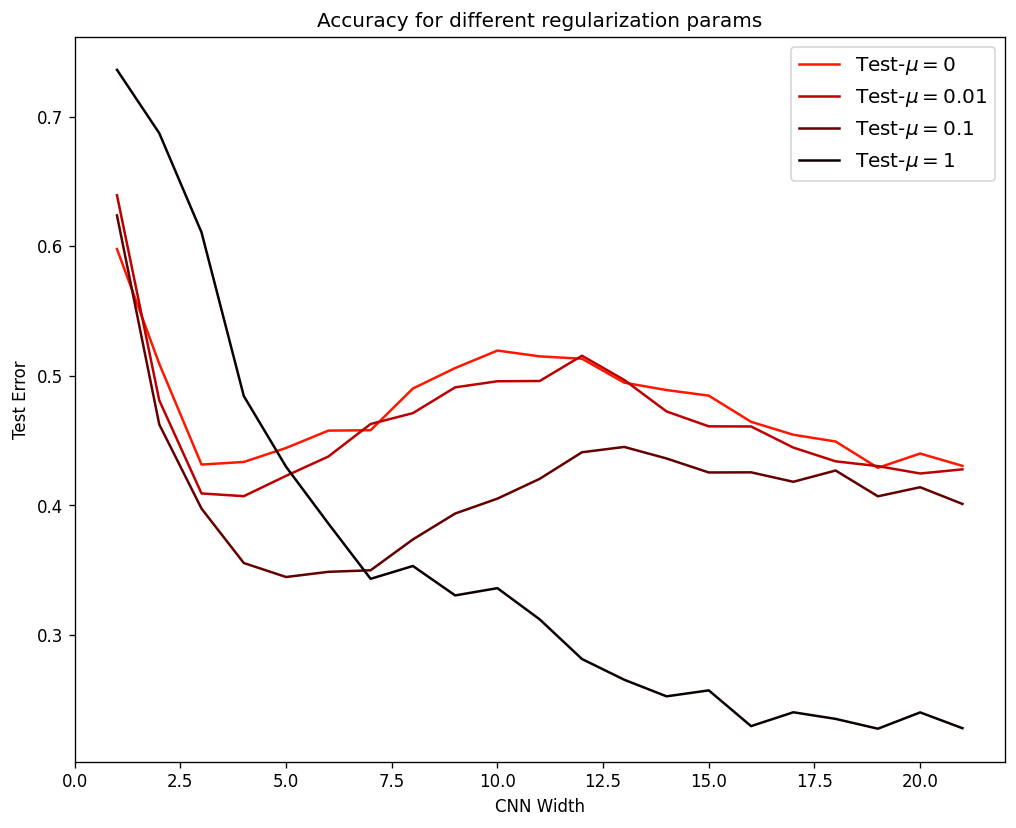

In [ ]:
#@title Test error vs CNN width various regularization params

viridis = cm.get_cmap('hot').reversed()
colormap = viridis
colors = [colormap(i) for i in np.linspace(0.6, 1, 4)]

plt.figure(figsize=(10, 8), dpi=120)

plt.plot(np.arange(1,width+1),1-dic[0][5][:,-1],color= colors[0])
#plt.plot(np.arange(width),1-dic[0][1][:,-1],color="royalblue",linestyle="dashed")
plt.plot(np.arange(1,width+1),1-dic[0.01][5][:,-1],color=colors[1])
#plt.plot(np.arange(width),1-dic[0.01][1][:,-1],color="darkorange",linestyle="dashed")
plt.plot(np.arange(1,width+1),1-dic[0.1][5][:,-1],color=colors[2])
#plt.plot(np.arange(width),1-dic[0.1][1][:,-1],color="limegreen",linestyle="dashed")
plt.plot(np.arange(1,width+1),1-dic[1][5][:,-1],color=colors[3])
plt.xlabel("CNN Width")
plt.ylabel("Test Error")
plt.title("Accuracy for different regularization params")
plt.legend(["Test-$\mu=0$","Test-$\mu=0.01$","Test-$\mu=0.1$","Test-$\mu=1$"],loc="upper right",prop={"size":12})
#plt.grid()

plt.show()

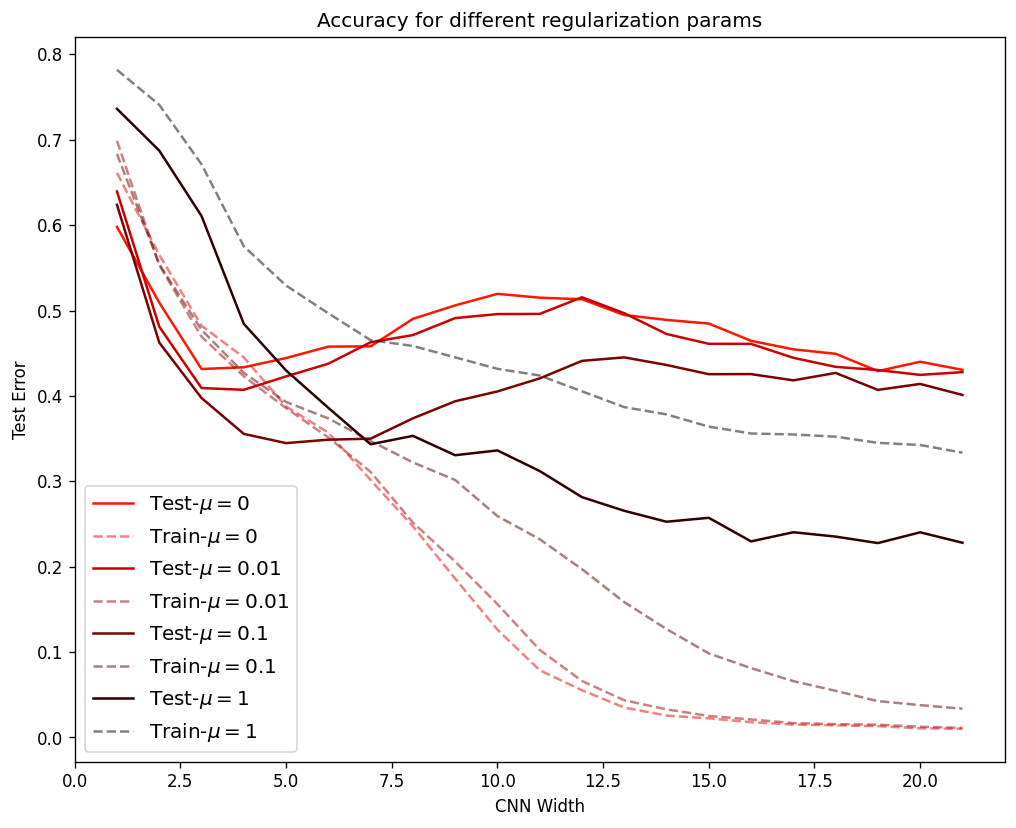

In [ ]:
#@title Test error different regularizations vs train error
viridis = cm.get_cmap('hot').reversed()
colormap = viridis
colors = [colormap(i) for i in np.linspace(0.6, 1, 8)]

plt.figure(figsize=(10, 8), dpi=120)

plt.plot(np.arange(1,width+1),1-dic[0][5][:,-1],color= colors[0])
plt.plot(np.arange(1,1+width),1-dic[0][1][:,-1],color=colors[1],linestyle="dashed",alpha=0.5)
plt.plot(np.arange(1,width+1),1-dic[0.01][5][:,-1],color=colors[2])
plt.plot(np.arange(1,1+width),1-dic[0.01][1][:,-1],color=colors[3],linestyle="dashed",alpha=0.5)
plt.plot(np.arange(1,width+1),1-dic[0.1][5][:,-1],color=colors[4])
plt.plot(np.arange(1,1+width),1-dic[0.1][1][:,-1],color=colors[5],linestyle="dashed",alpha=0.5)
plt.plot(np.arange(1,width+1),1-dic[1][5][:,-1],color=colors[6])
plt.plot(np.arange(1,1+width),1-dic[1][1][:,-1],color=colors[7],linestyle="dashed",alpha=0.5)

plt.xlabel("CNN Width")
plt.ylabel("Test Error")
plt.title("Accuracy for different regularization params")
plt.legend(["Test-$\mu=0$","Train-$\mu=0$","Test-$\mu=0.01$","Train-$\mu=0.01$","Test-$\mu=0.1$","Train-$\mu=0.1$","Test-$\mu=1$","Train-$\mu=1$"],loc="lower left",prop={"size":12})
#plt.grid()

plt.show()

